# How can restaurant hook potential Yelp reviews with high-stars
- Data Description: https://www.yelp.com/dataset/documentation/main

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from sklearn.lda import LDA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import IsolationForest, RandomForestRegressor

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module wi

In [2]:
yelp = pd.read_csv("Data/yelp.csv")

## 1. Feature Engineering

### 1.1. Extract all numeric features and nan values

In [3]:
numerics = ['review_stars', 'review_funny', 'review_cool', 'review_useful', 'review_len', 'review_afinn_score', 
            'review_polarity', 'review_compound', 'review_positive', 'review_negative', 'review_neutral', 
            'tip_compliment_count', 'tip_len', 'tip_afinn_score', 'tip_polarity', 'tip_compound', 'tip_positive', 
            'tip_negative', 'tip_neutral', 'user_review_count', 'user_useful', 'user_funny', 'user_cool', 'fans',
            'user_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 
            'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 
            'compliment_writer', 'compliment_photos', 'num_elite', 'num_friends', 'days_with_yelp', 
            'count_categories', 'latitude', 'longitude', 'business_review_count', 'business_stars', 'Monday', 
            'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'drink', 'food', 'inside', 'menu', 
            'outside', 'avg_checkin', 'checkin_count', 'var_checkin', 'b_tip_compliment_count', 'b_tip_len', 
            'b_tip_afinn_score', 'b_tip_polarity', 'b_tip_compound', 'b_tip_positive', 'b_tip_negative', 
            'b_tip_neutral']

In [4]:
yelp = yelp[yelp.review_cool.map(type) != str].dropna(how="any")

In [5]:
yelp.review_cool = yelp.review_cool.astype("float")

### 1.2. Normalization

In [6]:
normalized = (yelp[numerics].iloc[:, 1:] - yelp[numerics].iloc[:, 1:].mean()) / yelp[numerics].iloc[:, 1:].std()
normalized.head()

,review_funny,review_cool,review_useful,review_len,review_afinn_score,review_polarity,review_compound,review_positive,review_negative,review_neutral,...,checkin_count,var_checkin,b_tip_compliment_count,b_tip_len,b_tip_afinn_score,b_tip_polarity,b_tip_compound,b_tip_positive,b_tip_negative,b_tip_neutral
0,0.216965,-0.245479,1.254316,-0.701266,-2.753575,-2.452194,-2.457738,-1.669184,2.004916,0.827156,...,0.014559,-0.168610,1.918592,0.743095,-1.019162,-0.592703,-0.797358,-0.731201,0.470957,0.722571
1,-0.203029,-0.245479,0.174090,-0.485066,-0.333779,-1.106913,0.205992,-0.474744,0.067976,0.499728,...,-0.254337,-0.123773,-0.263987,-0.188357,0.052601,-0.042712,0.125916,-0.233000,-0.785813,0.718543
2,-0.203029,-0.245479,0.444147,1.200587,-2.254252,-1.216601,-2.821636,-0.964133,2.360318,-0.155127,...,0.014559,-0.168610,1.918592,0.743095,-1.019162,-0.592703,-0.797358,-0.731201,0.470957,0.722571
3,-0.203029,-0.245479,-0.366023,-0.451670,-0.909921,0.057429,-1.979682,-0.640638,2.129307,-0.389003,...,-0.208261,-0.165616,0.495171,-0.137152,-1.241188,-1.266835,-1.326992,-1.160595,0.530493,0.996752
4,-0.203029,-0.245479,-0.366023,-0.815518,0.472819,-0.012084,0.378984,0.504034,-0.020875,-0.557395,...,-0.092711,-0.168261,1.146973,0.650093,-0.554476,-0.522657,-0.565306,-0.476622,0.490852,0.545425


## 2. Modelling

### 2.1. Anomaly Detection: check extreme outliers

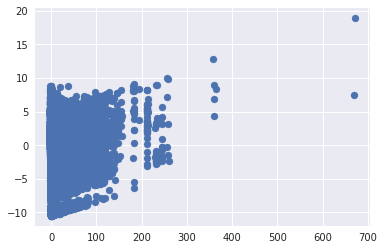

In [28]:
var2 = PCA(n_components=2).fit_transform(normalized)
plt.scatter(var2[:, 0], var2[:, 1])

In [30]:
sum(var2[:, 0] > 300)

7

### 2.2. Split

In [32]:
train_x, test_x, train_y, test_y = train_test_split(normalized, yelp["review_stars"], train_size=0.7, random_state=999)

### 2.3. Metrics

In [33]:
def Accuracies(y_true, y_pred):
    accuracy1 = sum(y_pred == y_true) / len(y_true)
    accuracy2 = sum(y_pred <= y_true) / len(y_true)
    return accuracy1, accuracy2

### 2.4. Random Forest

In [36]:
rdf = RandomForestRegressor()
rdf.fit(train_x, train_y)
rdf_y = rdf.predict(test_x).round(0)
accuracies = Accuracies(test_y, rdf_y)
print("Precise Accuracy: %.3f"%accuracies[0])
print("Benefit Accuracy: %.3f"%accuracies[1])

Precise Accuracy: 0.559
Benefit Accuracy: 0.789


In [37]:
pd.Series(rdf_y).value_counts()

4.0    698989
5.0    658172
3.0    234692
2.0    221090
1.0    187913
dtype: int64

Text(0.5,1,'RandomForestRegressor Features (avg over folds)')

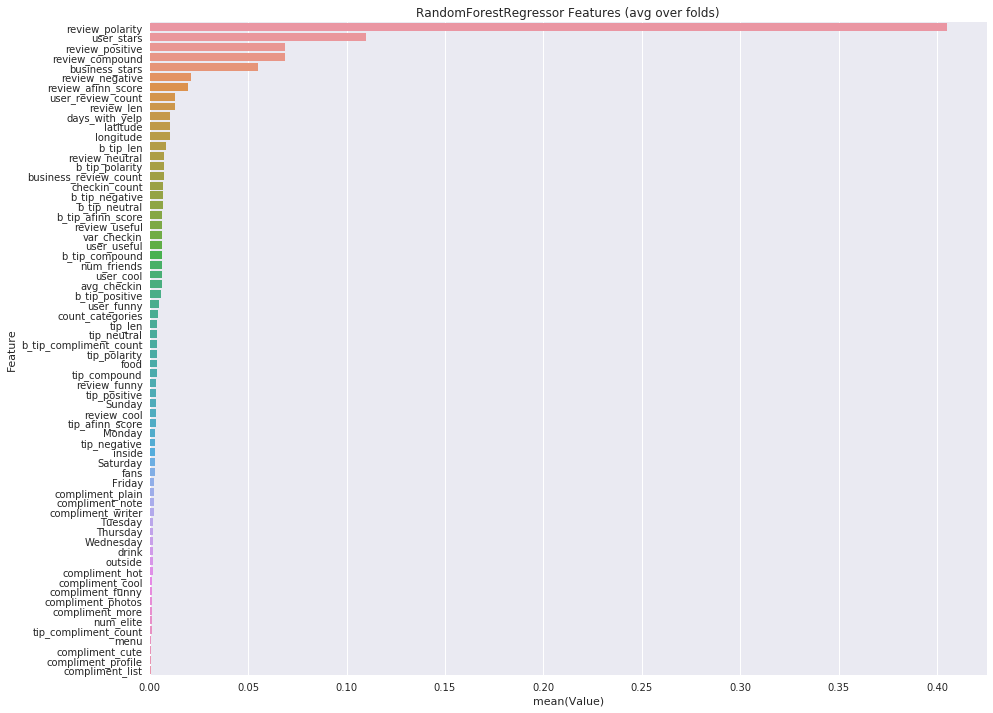

In [48]:
f = plt.figure(figsize=(15, 12))

feature_imp = pd.DataFrame(sorted(zip(rdf.feature_importances_, train_x.columns)), columns=['Value', 'Feature'])

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RandomForestRegressor Features (avg over folds)')

### 2.5. LGBM

In [42]:
lgbm = LGBMRegressor()
lgbm.fit(train_x, train_y)
lgbm_y = lgbm.predict(test_x).round(0)
accuracies = Accuracies(test_y, lgbm_y)
print("Precise Accuracy: %.3f"%accuracies[0])
print("Benefit Accuracy: %.3f"%accuracies[1])

Precise Accuracy: 0.578
Benefit Accuracy: 0.785


In [43]:
pd.Series(lgbm_y).value_counts()

5.0    707963
4.0    646954
3.0    252146
2.0    199110
1.0    194595
0.0        74
6.0        14
dtype: int64

Text(0.5,1,'LightGBM Features (avg over folds)')

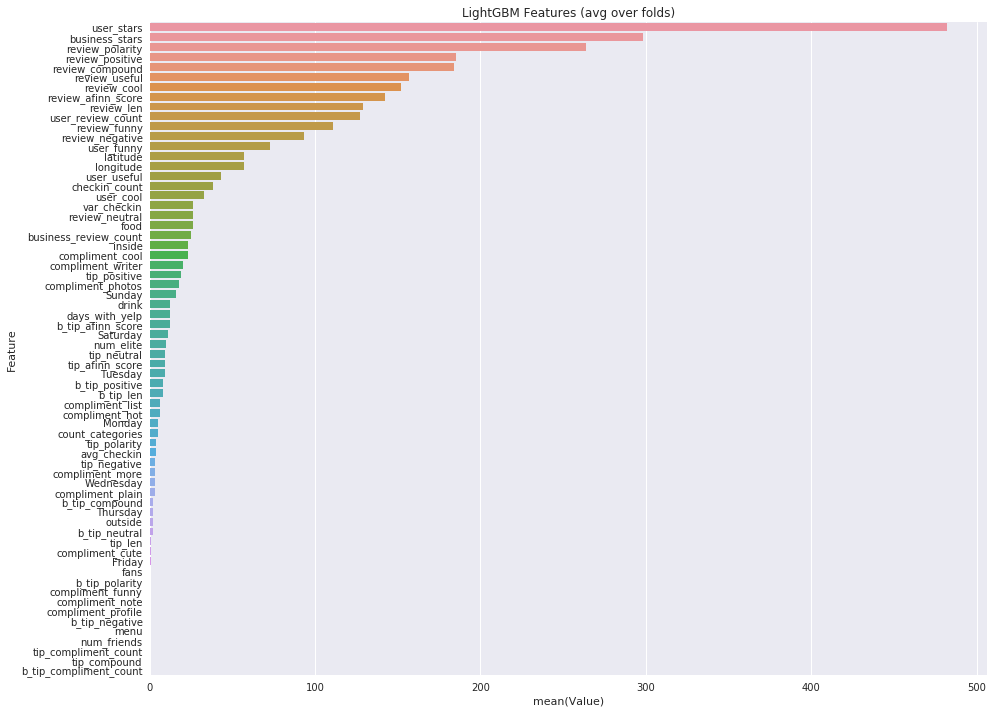

In [50]:
f = plt.figure(figsize=(15, 12))

feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, train_x.columns)), columns=['Value', 'Feature'])

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')